Autocorrelation models are very simple and can provide a fast and effective way to make skillful one-step and multi-step forecasts for electricity consumption. In this tutorial, you will discover how to develop and evaluate an autoregression model for multi-step forecasting household power consumption. After completing this tutorial, you will know:
- How to create and analyze autocorrelation and partial autocorrelation plots for univariate time series data.
- How to use the findings from autocorrelation plots to configure an autoregression model.
- How to develop and evaluate an autocorrelation model used to make one-week forecasts.


## 18.1 Tutorial Overview
This tutorial is divided into five parts; they are:
1. Problem Description
2. Load and Prepare Dataset
3. Model Evaluation
4. Autocorrelation Analysis
5. Develop an Autoregressive Model

## 18.2 Problem Description
The Household Power Consumption dataset is a multivariate time series dataset that describes the electricity consumption for a single household over four years. The data was collected between December 2006 and November 2010 and observations of power consumption within the household were collected every minute. It is a multivariate series comprised of seven variables
(besides the date and time); they are:
- global_active_power: The total active power consumed by the household (kilowatts).
- global_reactive_power: The total reactive power consumed by the household (kilowatts). 􏰀 voltage: Average voltage (volts).
- global_intensity: Average current intensity (amps).
- sub_metering_1: Active energy for kitchen (watt-hours of active energy).
- sub_metering_2: Active energy for laundry (watt-hours of active energy).
- sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

Active and reactive energy refer to the technical details of alternative current. A fourth sub-metering variable can be created by subtracting the sum of three defined sub-metering variables from the total active energy.

## 18.4 Model Evaluation

## 18.5 Autocorrelation Analysis

Statistical correlation summarizes the strength of the relationship between two variables. We can assume the distribution of each variable fits a __Gaussian (bell curve) distribution__. If this is the case, we can use the __Pearson’s correlation coefficient__ to summarize the correlation between the variables. The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

1. calculate the correlation for time series observations with observations with previous time steps, call lags. This is a serial correlation, or an autocorrelation. A plot of the autocorrelation of a time series by lag is called the __AutoCorrelation Function__. A __partial autocorrelation function__ or PACF is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

2. autocorrelation: direct correlation + indirect correlations. Indirect is a linear function of the correlation of the observation, with observations at intervening time steps. It is these indirect correlations that the partial autocorrelation function seeks to __remove__. We can calculate autocorrelation and partial autocorrelation plots using the __plot_acf()__ and __plot_pacf()__ Statsmodels functions respectively. 

3. In order to calculate and plot the autocorrelation, we must convert the data into a univariate time series. Specifically, the observed daily total power consumed.

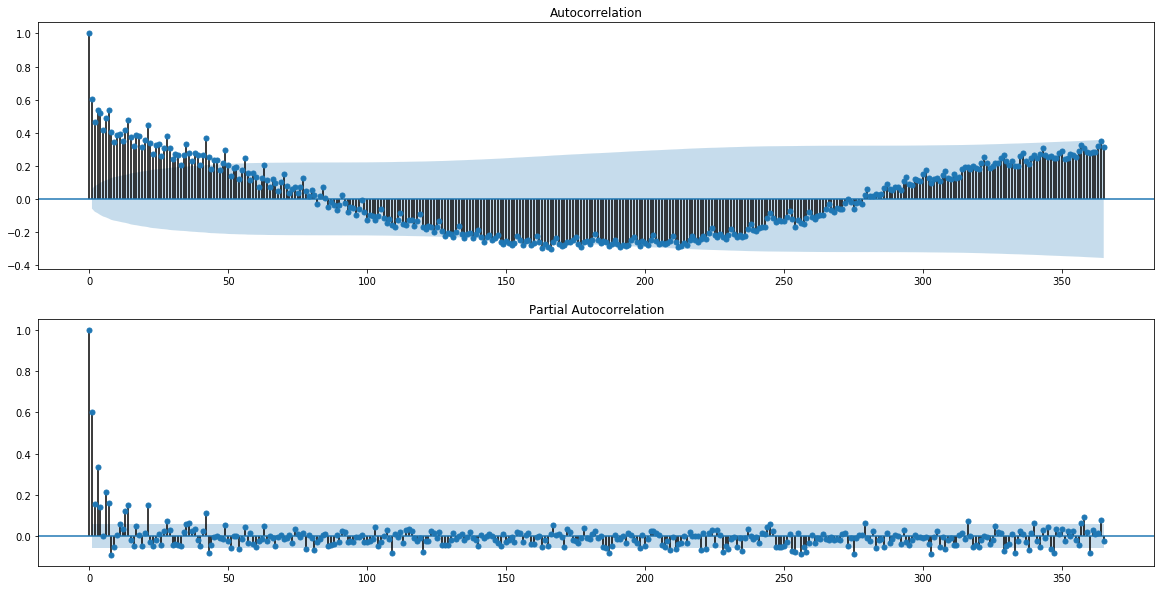

In [3]:
# acf and pacf plots of total power usage
from numpy import split
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
pyplot.rcParams["figure.figsize"] = (20,10)

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# convert training data into a series
series = to_series(train)
# plots
pyplot.figure()
lags = 365
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

Nevertheless, we might be able to see a familiar autoregression pattern. We might also see some significant lag observations at one year out. Further investigation may suggest a seasonal autocorrelation component, which would not be a surprising finding.


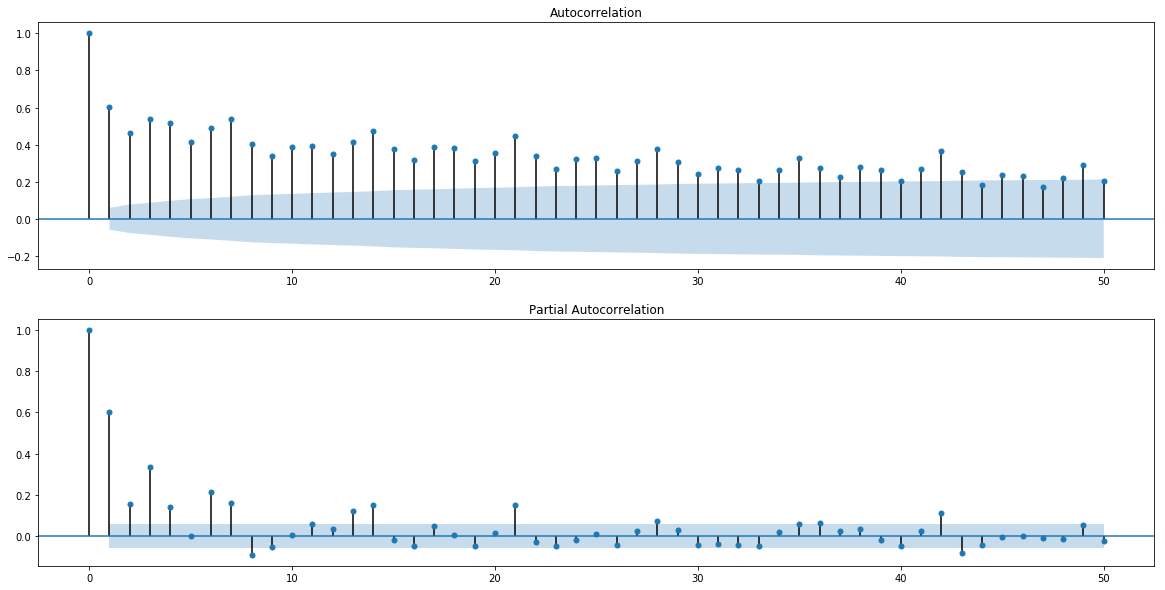

In [9]:
pyplot.figure()
lags = 50
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

We can clearly see a familiar autoregression pattern across the two plots. This pattern is comprised of two elements:
- ACF: A large number of significant lag observations that slowly degrade as the lag increases.
- PACF: A few significant lag observations that abruptly drop as the lag increases.

The ACF plot indicates that there is a strong autocorrelation component, whereas the PACF plot indicates that this component is distinct for the first approximately seven lag observations. This suggests that a good starting model would be an __AR(7)__; that is an autoregression model with seven lag observations used as input.

## 18.6 Develop an Autoregressive Model

We will use the ARIMA implementation as it allows for easy expandability into differencing and moving average.

arima: [381.594] 393.8, 398.9, 357.0, 377.1, 393.8, 306.0, 432.2


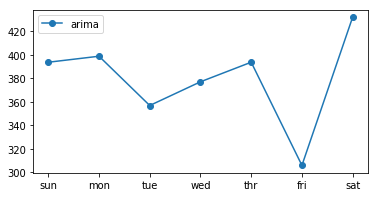

In [11]:
# arima forecast for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
pyplot.rcParams["figure.figsize"] = (6,3)

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# evaluate a single model
def evaluate_model(model_func, train, test):
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = model_func(history)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	predictions = array(predictions)
	# evaluate predictions days for each week
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# convert windows of weekly multivariate data into a series of total power
def to_series(data):
	# extract just the total power from each week
	series = [week[:, 0] for week in data]
	# flatten into a single series
	series = array(series).flatten()
	return series

# arima forecast
def arima_forecast(history):
	# convert history into a univariate series
	series = to_series(history)
	# define the model
	model = ARIMA(series, order=(7,0,0))
	# fit the model
	model_fit = model.fit(disp=False)
	# make forecast
	yhat = model_fit.predict(len(series), len(series)+6)
	return yhat

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
	# evaluate and get scores
	score, scores = evaluate_model(func, train, test)
	# summarize scores
	summarize_scores(name, score, scores)
	# plot scores
	pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()

Running the example first prints the performance of the AR(7) model on the test dataset. We can see that the model achieves the overall RMSE of about 381 kilowatts. This model has skill when compared to naive forecast models, such as a model that forecasts the week ahead using observations from the same time one year ago that achieved an overall RMSE of about 465 kilowatts.

## 18.8 Further Reading
This section provides more resources on the topic if you are looking to go deeper.
- statsmodels.graphics.tsaplots.plot acf API. http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
- statsmodels.graphics.tsaplots.plot pacf API. http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html
- statsmodels.tsa.arima model.ARIMA API. http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
- statsmodels.tsa.arima model.ARIMAResults API. http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.html


## 18.9 Summary
In this tutorial, you discovered how to develop and evaluate an autoregression model for multi-step forecasting household power consumption. Specifically, you learned:
- How to create and analyze autocorrelation and partial autocorrelation plots for univariate time series data.
- How to use the findings from autocorrelation plots to configure an autoregression model.
- How to develop and evaluate an autocorrelation model used to make one-week forecasts.